## Note: Increased IOPub
For visualization, if you did not start this notebook with an increased data rate limit, stop the notebook, go back to the command line, and start Jupyter Notebook using the following command.

`jupyter notebook --NotebookApp.iopub_data_rate_limit=10000000000`

# Import the Python API module and Instantiate the GIS object

Import the Python API

In [1]:
import arcgis
from getpass import getpass
import pandas as pd

ImportError: No module named 'arcgis'

Create an GIS object instance using the [account currently logged in through ArcGIS Pro](https://developers.arcgis.com/python/guide/working-with-different-authentication-schemes/#ArcGIS-Pro-user-connecting-to-the-active-portal-in-the-Pro-app)

In [2]:
# gis_retail = arcgis.gis.GIS('Pro')  # optional, use if can use ArcGIS Pro authentication
gis = arcgis.gis.GIS(
    username='jmccune_retail', 
    password=getpass('Please enter the headless password: ')
)

Please enter the headless password: ········


# Get a Data Frame, data to work with, from the Web GIS Item ID

Create a [Web GIS Item](http://esri.github.io/arcgis-python-api/apidoc/html/arcgis.gis.toc.html#item) instance using the Item ID

<Item title:"targetWithDemographics" type:Feature Layer Collection owner:joel5174@esri.com_commteamretail>
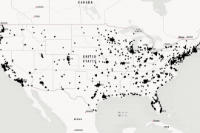

In [3]:
trade_area_itemid = '44c0b666404c41b8a14e04c34d09be1e'
item = arcgis.gis.Item(gis=gis, itemid=trade_area_itemid)
item

Since the item only contains one feature layer, get the first layer in the item, the [Feature Layer](http://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#featurelayer) we need to work with.

In [4]:
feature_layer = item.layers[0]
feature_layer

<FeatureLayer url:"https://services.arcgis.com/PMTtzuTB6WiPuNSv/arcgis/rest/services/targetWithDemographics/FeatureServer/0">

Use [query](http://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#arcgis.features.FeatureLayer.query) to return the data as a [Feature Set](http://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#featureset).

In [5]:
feature_set = feature_layer.query()

In [6]:
df_fields = pd.DataFrame([(field['name'], field['alias']) for field in feature_set.fields], columns=['NAME', 'ALIAS'])
df_fields

,NAME,ALIAS
0,OBJECTID,Object ID
1,Target_Locations_LOCNUM,LOCNUM
2,Target_Locations_CONAME,CONAME
3,Target_Locations_STREET,STREET
4,Target_Locations_CITY,CITY
5,Target_Locations_STATE,STATE
6,Target_Locations_ZIP,ZIP
7,Target_Locations_ZIP4,ZIP4
8,Target_Locations_NAICS,NAICS
9,Target_Locations_SIC,SIC


Take advantage of the [`df` function](http://esri.github.io/arcgis-python-api/apidoc/html/arcgis.features.toc.html#arcgis.features.FeatureSet.df) on the Feature set object returned from the query to convert the data to a [Pandas Data Frame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html).

In [7]:
df = feature_set.df
df.head()

,OBJECTID,Target_Locations_CITY,Target_Locations_CONAME,Target_Locations_LOCNUM,Target_Locations_NAICS,Target_Locations_SALESVOL,Target_Locations_SIC,Target_Locations_SQFTCODE,Target_Locations_STATE,Target_Locations_STREET,...,overlayTemplate_VAL200K_CY,overlayTemplate_VAL250K_CY,overlayTemplate_VAL300K_CY,overlayTemplate_VAL400K_CY,overlayTemplate_VAL500K_CY,overlayTemplate_VAL50K_CY,overlayTemplate_VAL750K_CY,overlayTemplate_WHITE_CY,overlayTemplate_WIDOWED_CY,SHAPE
0,1,SEASIDE,TARGET,666990510,45211101,35495,531102,D,CA,CALIFORNIA AVE,...,200,354,934,693,1976,81,1012,23576,1902,"{'x': -121.84299999999993, 'y': 36.62100000000..."
1,2,MARINA,TARGET,653371815,45211101,35495,531102,D,CA,GENERAL STILLWELL DR,...,137,270,1043,742,1612,81,588,21068,1500,"{'x': -121.81120000000001, 'y': 36.66760000000..."
2,3,CAPITOLA,TARGET,423468472,45211101,35495,531102,D,CA,41ST AVE,...,372,405,1015,1271,4018,261,2452,41050,2524,"{'x': -121.96509999999991, 'y': 36.9753000000001}"
3,4,WATSONVILLE,TARGET,511743478,45211101,35495,531102,D,CA,MAIN ST,...,456,449,870,982,1211,197,293,19905,1323,"{'x': -121.77399999999992, 'y': 36.91540000000..."
4,5,CUPERTINO,TARGET,404459478,45211101,52059,531102,D,CA,STEVENS CREEK BLVD,...,43,49,211,519,2823,110,7694,41689,5226,"{'x': -122.03619999999995, 'y': 37.32310000000..."


Because I am neurotic, and hate the prefixes added to the field names from the join when preparing the data in ArcMap, we are cleaning them up a little here.

In [8]:
df.columns = [field.replace('Target_Locations_', '').replace('overlayTemplate_', '') for field in df.columns]
df.head()

,OBJECTID,CITY,CONAME,LOCNUM,NAICS,SALESVOL,SIC,SQFTCODE,STATE,STREET,...,VAL200K_CY,VAL250K_CY,VAL300K_CY,VAL400K_CY,VAL500K_CY,VAL50K_CY,VAL750K_CY,WHITE_CY,WIDOWED_CY,SHAPE
0,1,SEASIDE,TARGET,666990510,45211101,35495,531102,D,CA,CALIFORNIA AVE,...,200,354,934,693,1976,81,1012,23576,1902,"{'x': -121.84299999999993, 'y': 36.62100000000..."
1,2,MARINA,TARGET,653371815,45211101,35495,531102,D,CA,GENERAL STILLWELL DR,...,137,270,1043,742,1612,81,588,21068,1500,"{'x': -121.81120000000001, 'y': 36.66760000000..."
2,3,CAPITOLA,TARGET,423468472,45211101,35495,531102,D,CA,41ST AVE,...,372,405,1015,1271,4018,261,2452,41050,2524,"{'x': -121.96509999999991, 'y': 36.9753000000001}"
3,4,WATSONVILLE,TARGET,511743478,45211101,35495,531102,D,CA,MAIN ST,...,456,449,870,982,1211,197,293,19905,1323,"{'x': -121.77399999999992, 'y': 36.91540000000..."
4,5,CUPERTINO,TARGET,404459478,45211101,52059,531102,D,CA,STEVENS CREEK BLVD,...,43,49,211,519,2823,110,7694,41689,5226,"{'x': -122.03619999999995, 'y': 37.32310000000..."


# Store Segmentation Using KMeans Clustering

Use KMeans cluster analysis from the Sci-Kit Learn package to segment the demographically similar stores together.

In [9]:
from sklearn.cluster import KMeans
import pandas as pd
import numpy as np

%matplotlib inline

Create the KMeans clusterer, specifying it to create five clusters, or segments.

In [10]:
km = KMeans(n_clusters=5)

Use the `fit_predict` method to create the clusters using just the numeric fields - not including the OID and sales fields.

In [11]:
df_independent = df.select_dtypes(include=[np.number]).drop(['OBJECTID', 'SALESVOL'], axis=1)
fields_independent = df_independent.columns  # save for later
field_name_dependent = 'SALESVOL' # keep track of this as well

In [12]:
df['segment'] = km.fit_predict(df_independent)

In [13]:
df.head()

,OBJECTID,CITY,CONAME,LOCNUM,NAICS,SALESVOL,SIC,SQFTCODE,STATE,STREET,...,VAL250K_CY,VAL300K_CY,VAL400K_CY,VAL500K_CY,VAL50K_CY,VAL750K_CY,WHITE_CY,WIDOWED_CY,SHAPE,segment
0,1,SEASIDE,TARGET,666990510,45211101,35495,531102,D,CA,CALIFORNIA AVE,...,354,934,693,1976,81,1012,23576,1902,"{'x': -121.84299999999993, 'y': 36.62100000000...",0
1,2,MARINA,TARGET,653371815,45211101,35495,531102,D,CA,GENERAL STILLWELL DR,...,270,1043,742,1612,81,588,21068,1500,"{'x': -121.81120000000001, 'y': 36.66760000000...",0
2,3,CAPITOLA,TARGET,423468472,45211101,35495,531102,D,CA,41ST AVE,...,405,1015,1271,4018,261,2452,41050,2524,"{'x': -121.96509999999991, 'y': 36.9753000000001}",4
3,4,WATSONVILLE,TARGET,511743478,45211101,35495,531102,D,CA,MAIN ST,...,449,870,982,1211,197,293,19905,1323,"{'x': -121.77399999999992, 'y': 36.91540000000...",0
4,5,CUPERTINO,TARGET,404459478,45211101,52059,531102,D,CA,STEVENS CREEK BLVD,...,49,211,519,2823,110,7694,41689,5226,"{'x': -122.03619999999995, 'y': 37.32310000000...",3


# Investigate the Results

Now, take a look at a few descriptive metrics to begin to understand the results - initially by creating a data frame with the segments, mean sales for each segment, median sales for each segment, and the median sales for each segment.

In [14]:
df_count = df.segment.value_counts().reset_index().rename(columns={'index': 'segment', 'segment': 'count'})
df_mean = df.groupby('segment').mean()[field_name_dependent].reset_index().rename(
    columns={'segment': 'segment', field_name_dependent: 'mean_sales'})
df_median = df.groupby('segment').median()[field_name_dependent].reset_index().rename(
    columns={'segment': 'segment', field_name_dependent: 'median_sales'})

In [15]:
df_summary = pd.merge(df_count, df_mean)
df_summary = pd.merge(df_summary, df_median)
df_summary = df_summary.sort_values('mean_sales', ascending=False)
df_summary['mean_sales_zscore'] = df_summary.apply(lambda row: (row.mean_sales - df.SALESVOL.mean()) / df.SALESVOL.std(ddof=0), axis=1)
print('Sales Mean: {:.2f}\nSales Standard Deviation: {:.2f}'.format(df.SALESVOL.mean(), df.SALESVOL.std()))
df_summary

Sales Mean: 35147.10
Sales Standard Deviation: 17891.99


,segment,count,mean_sales,median_sales,mean_sales_zscore
4,3,52,45732.500000,42130.5,0.591792
3,1,208,40657.115385,35495.0,0.308045
2,2,360,38065.166667,35495.0,0.163139
1,4,536,34590.748134,33751.0,-0.031103
0,0,652,31391.226994,32268.0,-0.209977


Now, using data from this data frame, visualize the means of each segment against the mean, and one-half standard deviation above and below the mean.

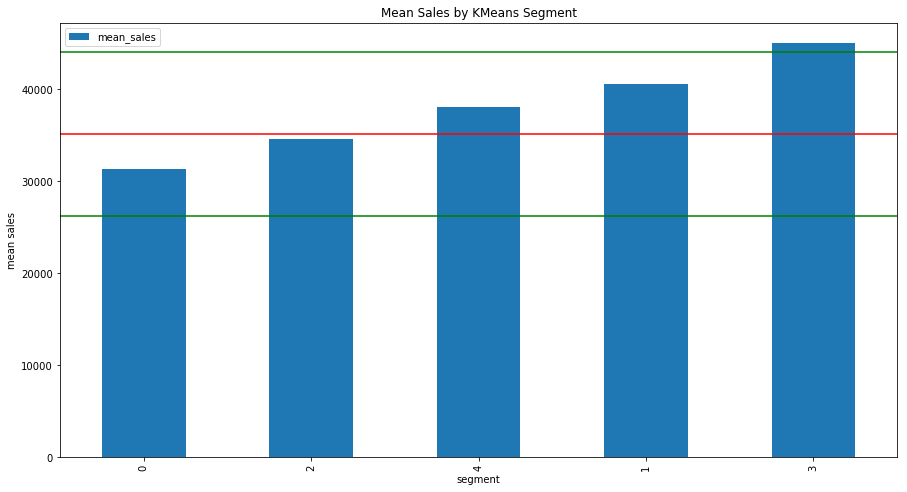

In [18]:
ax = df_summary.sort_values('mean_sales').plot.bar(y='mean_sales', x='segment', figsize=(15, 8))
ax.set_ylabel('mean sales')
ax.set_title('Mean Sales by KMeans Segment')

ax.axhline(y=df.SALESVOL.mean(), color='r') # add the mean for reference
ax.axhline(y=df.SALESVOL.mean() - df.SALESVOL.std() * 0.5, color='g')
ax.axhline(y=df.SALESVOL.mean() + df.SALESVOL.std() * 0.5, color='g')

In [21]:
df['segment_3'] = df.segment == 3
df

,OBJECTID,CITY,CONAME,LOCNUM,NAICS,SALESVOL,SIC,SQFTCODE,STATE,STREET,...,VAL300K_CY,VAL400K_CY,VAL500K_CY,VAL50K_CY,VAL750K_CY,WHITE_CY,WIDOWED_CY,SHAPE,segment,segment_3
0,1,SEASIDE,TARGET,666990510,45211101,35495,531102,D,CA,CALIFORNIA AVE,...,934,693,1976,81,1012,23576,1902,"{'x': -121.84299999999993, 'y': 36.62100000000...",0,False
1,2,MARINA,TARGET,653371815,45211101,35495,531102,D,CA,GENERAL STILLWELL DR,...,1043,742,1612,81,588,21068,1500,"{'x': -121.81120000000001, 'y': 36.66760000000...",0,False
2,3,CAPITOLA,TARGET,423468472,45211101,35495,531102,D,CA,41ST AVE,...,1015,1271,4018,261,2452,41050,2524,"{'x': -121.96509999999991, 'y': 36.9753000000001}",4,False
3,4,WATSONVILLE,TARGET,511743478,45211101,35495,531102,D,CA,MAIN ST,...,870,982,1211,197,293,19905,1323,"{'x': -121.77399999999992, 'y': 36.91540000000...",0,False
4,5,CUPERTINO,TARGET,404459478,45211101,52059,531102,D,CA,STEVENS CREEK BLVD,...,211,519,2823,110,7694,41689,5226,"{'x': -122.03619999999995, 'y': 37.32310000000...",3,True
5,6,SAN JOSE,TARGET,373128867,45211101,84715,531102,D,CA,SARATOGA AVE,...,408,1002,7996,136,10636,70131,6289,"{'x': -121.99069999999993, 'y': 37.29280000000...",3,True
6,7,SUNNYVALE,TARGET,402344537,45211101,35495,531102,D,CA,W MC KINLEY AVE,...,874,1620,6575,351,7622,54321,4554,"{'x': -122.03229999999998, 'y': 37.37370000000...",3,True
7,8,SAN JOSE,TARGET,637354200,45211101,35495,531102,D,CA,BLOSSOM HILL RD,...,2347,4110,16914,847,8664,95636,6032,"{'x': -121.86139999999993, 'y': 37.25050000000...",3,True
8,9,SAN JOSE,TARGET,435039879,45211101,35495,531102,D,CA,COTTLE RD,...,2517,4531,12939,862,2895,60248,3932,"{'x': -121.80389999999996, 'y': 37.24990000000...",1,False
9,10,SAN JOSE,TARGET,230021602,45211101,70990,531102,D,CA,HILLSDALE AVE,...,994,2572,15838,284,11823,105854,6740,"{'x': -121.91809999999997, 'y': 37.26320000000...",3,True


In [24]:
df.groupby("segment_3").CITY.value_counts()

segment_3  CITY           
False      CHICAGO            14
           SAN ANTONIO        14
           HOUSTON            13
           LAS VEGAS          10
           AUSTIN              9
           CHARLOTTE           8
           COLUMBUS            8
           JACKSONVILLE        8
           KANSAS CITY         8
           MINNEAPOLIS         8
           PHOENIX             8
           SAN JOSE            8
           ST PAUL             8
           ATLANTA             7
           LOUISVILLE          7
           MIAMI               7
           PITTSBURGH          7
           SAN DIEGO           7
           SPRINGFIELD         7
           TUCSON              7
           AURORA              6
           CINCINNATI          6
           MILWAUKEE           6
           OMAHA               6
           ORLANDO             6
           PHILADELPHIA        6
           ROCHESTER           6
           SACRAMENTO          6
           TAMPA               6
           ALBUQ

# Map Results

After doing this analysis, we are going to begin by showing the locations of the top performing stores on the map relative to the rest of the stores.

In [17]:
top_segment = df_summary.iloc[0].segment
top_segment

3.0

This is a first stab at mapping the data just using the draw method, which plots the data on the map much like just using a sharpie. The data is not organized into a layer per say, so it is not very useful. Still, it is interesting at a coursory level, just seeing the rest of the stores, and the top performers.

In [26]:
store_map = gis.map('Meades Ranch, KS', 4)
store_map.basemap = 'gray'
store_map

A Jupyter Widget

In [19]:
for index, row in df[df.segment != top_segment].iterrows():
    store_map.draw(row.SHAPE, symbol={'type': 'esriSMS', 'style': 'esriSMSCircle', 'size': 4})
for index, row in df[df.segment == top_segment].iterrows():
    store_map.draw(row.SHAPE, symbol={'type': 'esriSMS', 'style': 'esriSMSCircle', "color":[0,255,0,255], "size":6})

# PCA

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [41]:
pca = PCA(n_components=2)

In [50]:
df['x'] = pca.fit_transform(df[fields_independent])[:,0]
df['y'] = pca.fit_transform(df[fields_independent])[:,1]

NameError: name 'cluster' is not defined

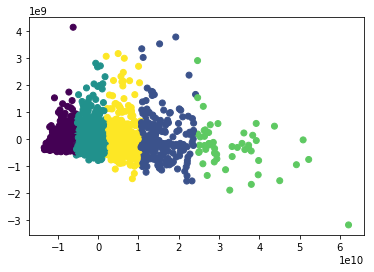

In [61]:
ax = plt.scatter(data=df, x='x', y='y', c='segment')

cluster_centers = pca.transform(cluster.cluster_centers_)
cluster_centers = pd.DataFrame(cluster_centers, columns=['x', 'y'])
cluster_centers['segment'] = range(0, len(cluster_centers))

plt.plot(data=cluster_centers)

plt.show()